In [95]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import string
import math
import nltk
import re
import random
import ast
import seaborn as sns
from nltk.stem import *

from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import hdbscan

In [96]:
#print(df.head())
with open('E:\\David\\Documents\\Northwestern\\W2018\\PRED 453\\Python Explore\\comments.csv', 'r',encoding='utf-8') as datafile:
	df = pd.read_csv(datafile)

with open('E:\\David\\Documents\\Northwestern\\W2018\\PRED 453\\Python Explore\\unigram_exclude.csv', 'r',encoding='utf-8') as datafile:
	exclude = pd.read_csv(datafile)
    
with open('E:\\David\\Documents\\Northwestern\\W2018\\PRED 453\\Python Explore\\unigram_replacement.csv', 'r',encoding='utf-8') as datafile:
	replacement = pd.read_csv(datafile)
    
# Tokenized comments
df_tokenized=pd.DataFrame()

In [97]:
# Regex remove special
# URLs
reg = re.compile(r"http[^\s]*",re.IGNORECASE)
df['body_html'].replace(to_replace=reg, value="", regex=True, inplace=True)

In [98]:
# Turn into tokens
df_tokenized['tokenized'] = df.apply(lambda row: word_tokenize(row['body_html']),axis=1)

# Lengths of comments
df_tokenized['length']=df_tokenized.apply(lambda row: len(row['tokenized']),axis=1)
#plt.figure(figsize=(20,10))
#plt.title('Comment Lengths')
#plt.hist(df_tokenized['length'],bins=30)
#plt.show()

# Remove stopwords, punctuation, and numbers
stop_words = set(stopwords.words('english'))
#stemmer = nltk.stem.SnowballStemmer('english')
lemma = WordNetLemmatizer()

# Remove non-words            
df_tokenized['tokenized'] = df_tokenized.apply(lambda row: [word for word in row['tokenized'] if word.isalpha()],axis=1) 

# Lower case first
df_tokenized['tokenized'] = df_tokenized.apply(lambda row: [word.lower() for word in row['tokenized']],axis=1)

# Remove stopwords
df_tokenized['tokenized'] = df_tokenized.apply(lambda row: [word for word in row['tokenized'] if not word in stop_words],axis=1) 

# Nouns only
df_tokenized['tokenized'] = df_tokenized.apply(lambda row: [word for (word,pos) in pos_tag(row['tokenized']) if pos.startswith('NN')],axis=1) 

# Stemming
#df_tokenized['tokenized'] = df_tokenized.apply(lambda row: [stemmer.stem(word) for word in row['tokenized']],axis=1) 
# Lemmatizing
df_tokenized['tokenized'] = df_tokenized.apply(lambda row: [lemma.lemmatize(word) for word in row['tokenized']],axis=1) 

In [99]:
# Remove excluded custom stop words
# for word in exclude.term: 
#     df_tokenized['tokenized'] = df_tokenized['tokenized'].replace(' '+word+' ', ' ')
def exclude_stopwords(tokens):
    return [word for word in tokens if not exclude.term.str.contains(word).any()]

df_tokenized['tokenized'] = df_tokenized['tokenized'].apply(lambda row: exclude_stopwords(row))


# print(df_tokenized.head())
# print(df_tokenized.iloc[64]['tokenized'])



In [100]:
# # Convert ECs
# def replace_ec(tokens):
#     return(tokens)

# print(df_tokenized.iloc[2148]['tokenized'])

def replace_ec(tokens):
    token_replaced = tokens
    for idx, word in enumerate(tokens):
        if np.sum(replacement["term"]==word) >0:
            token_replaced[idx] = replacement.loc[replacement["term"]==word,"replacement"].values[0]
    return(tokens)

df_tokenized['tokenized'] = df_tokenized['tokenized'].apply(lambda row: replace_ec(row))
    
# print(df_tokenized['tokenized'].str.join(" ").str.match('elon'))
# print(df_tokenized.iloc[2148]['tokenized'])

# print(replacement[replacement["term"]=='elon']["replacement"])

In [101]:
with open('tf.csv','w',encoding='utf-8') as tffile:
    df_tokenized.to_csv(tffile)
    
# df_backup = df_tokenized.copy()
# df_tokenized = df_backup.copy()
print(df_tokenized['tokenized'].head())

0    [technology, job, job, generation, generation,...
1    [gain, job, decade, research, organization, er...
2    [campaign, place, energy, obama, world, panel,...
3    [american, transport, taxi, car, ownership, se...
4                         [bet, mitt, romney, reality]
Name: tokenized, dtype: object


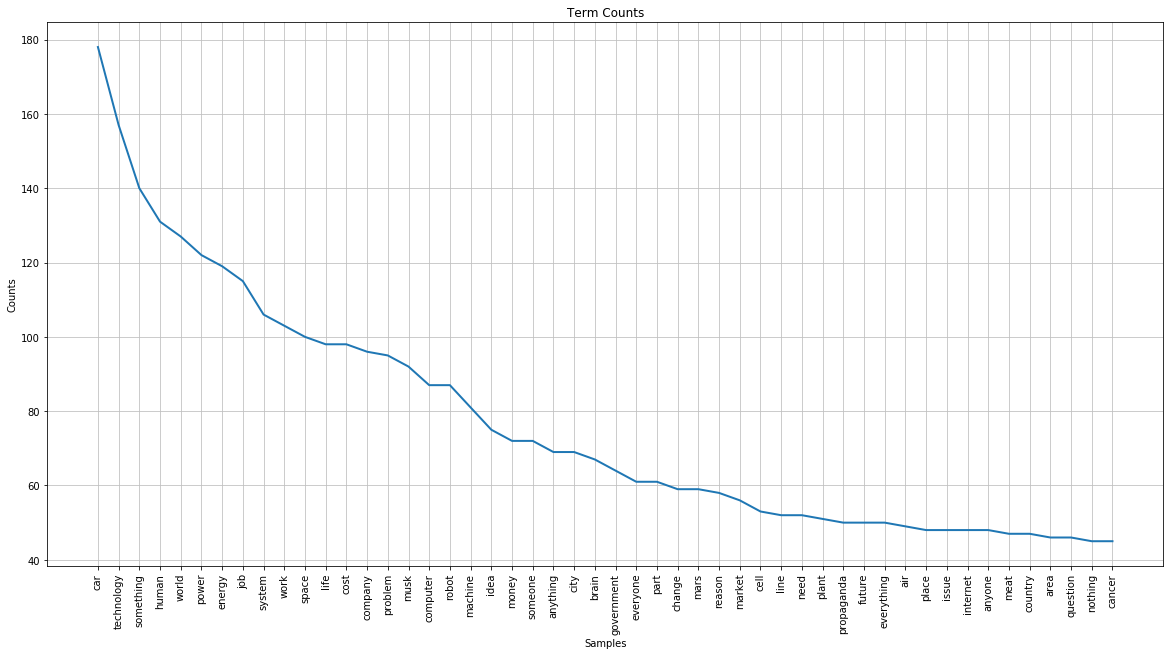

In [102]:
# All terms - frequency
tf_all = df_tokenized.tokenized.sum()
#print(tf_all[1:100])
fd = FreqDist(tf_all)
plt.figure(figsize=(20,10))
plt.title('Term Counts')
plt
fd.plot(50,cumulative=False)
top_terms = pd.DataFrame(list(filter(lambda x: x[1]>=5, fd.items())),columns=['term','frequency'])

In [103]:
#tm1 = top_terms.term[0]
#print(tm1)

#print(Counter(df_tokenized.tokenized[0])['me'])
#print(len(df_tokenized.tokenized[0]))
#print(math.log(df_tokenized.shape[0]/df_tokenized['tokenized'].apply(lambda row: tm1 in row).sum()))

#tf_list = list()
#idf_list = list()
#for tm in top_terms.term:
#    tf_list.append(Counter(df_tokenized.tokenized[idx])[tm]/len(df_tokenized.tokenized[idx]))
#    idf_list.append(math.log(df_tokenized.shape[0]/df_tokenized['tokenized'].apply(lambda row: tm in row).sum()))

#top_terms = top_terms.assign(tf=tf_list)
#top_terms = top_terms.assign(idf=idf_list)

#print(top_terms.head())

#top_terms['tfidf'] = top_terms.tf * top_terms.idf

#print(top_terms.head())
#print(top_terms.head())
#fd.plot(100,cumulative=False)

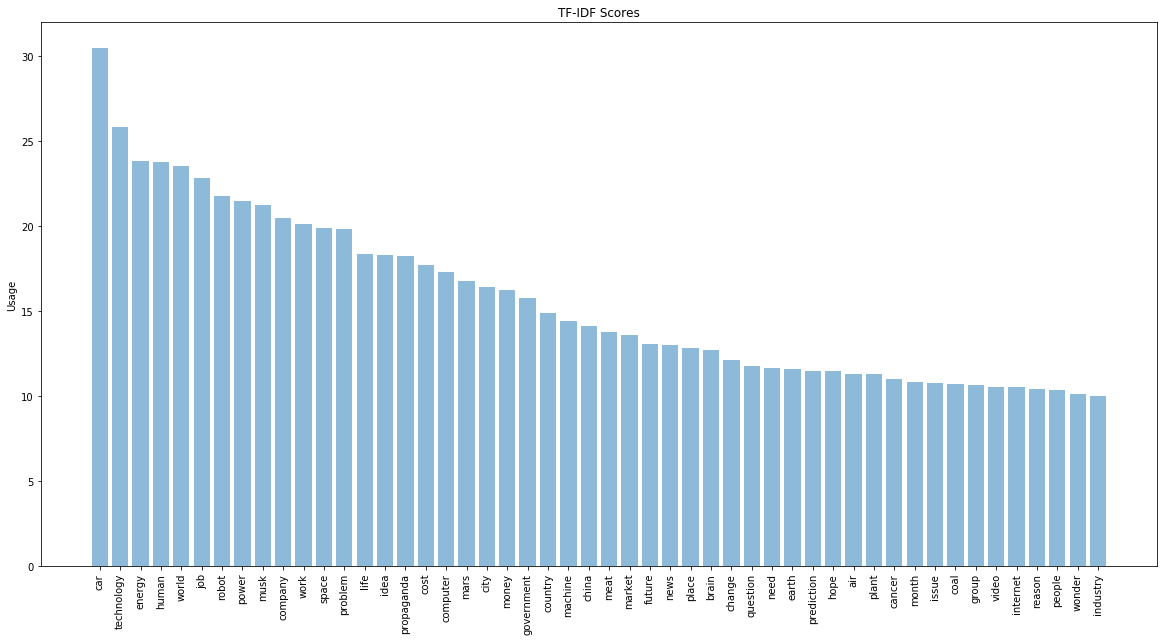

In [104]:
# Unigrams only
vectorizer = TfidfVectorizer(norm='l2', 
                             analyzer='word', 
                             token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b',
                             stop_words='english')
filtered_sent = df_tokenized.tokenized.apply(lambda row: " ".join(row))
X = vectorizer.fit_transform(filtered_sent)

scores = zip(vectorizer.get_feature_names(),
                 np.asarray(X.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
#for item in sorted_scores:
#    print(item)

term_scores1 = pd.DataFrame(sorted_scores,columns=['term','tfidfscore']).head(50)
y_pos = np.arange(len(term_scores1.term))

plt.figure(figsize=(20,10))
plt.bar(y_pos, term_scores1.tfidfscore, align='center', alpha=0.5)
plt.xticks(y_pos, term_scores1.term,rotation=90)
plt.ylabel('Usage')
plt.title('TF-IDF Scores')
plt.show()

#with open('term_tfidf.csv','w') as csvfile:
#    term_scores1.to_csv(csvfile)

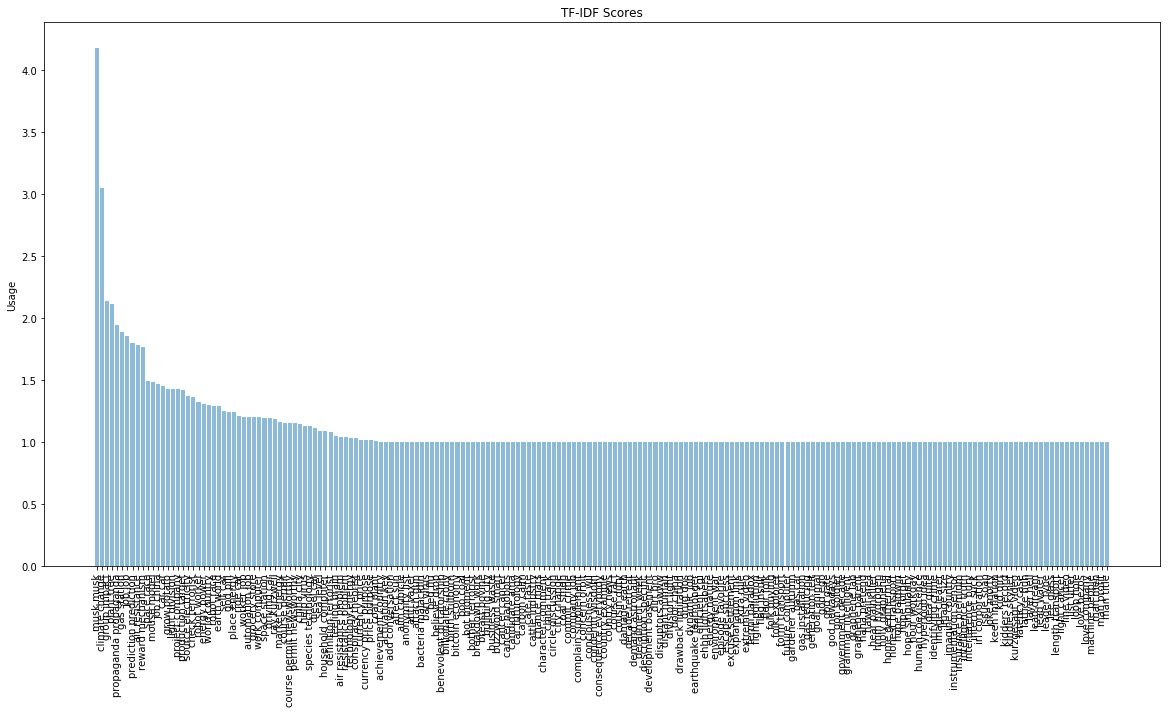

In [105]:
# Bigrams and Trigrams
vectorizer = TfidfVectorizer(norm='l2', 
                             analyzer='word', 
                             token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b',
                             stop_words='english',
                             ngram_range=(2,3))
filtered_sent = df_tokenized.tokenized.apply(lambda row: " ".join(row))
X = vectorizer.fit_transform(filtered_sent)

scores = zip(vectorizer.get_feature_names(),
                 np.asarray(X.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
#for item in sorted_scores:
#    print(item)

term_scores = pd.DataFrame(sorted_scores,columns=['term','tfidfscore']).head(200)
y_pos = np.arange(len(term_scores.term))

plt.figure(figsize=(20,10))
plt.bar(y_pos, term_scores.tfidfscore, align='center', alpha=0.5)
plt.xticks(y_pos, term_scores.term,rotation=90)
plt.ylabel('Usage')
plt.title('TF-IDF Scores')
plt.show()

#with open('23gram_term_tfidf.csv','w') as csvfile:
#    term_scores.to_csv(csvfile)

In [106]:
# print(term_scores1.term)

# Limit to selected terms
df_tokenized['tokenized'] = df_tokenized['tokenized'].apply(lambda row: [word for word in row if word in term_scores1.term.tolist()])
# print(df_tokenized.head(200))

# tf2 = FreqDist(df_tokenized.loc[0,"tokenized"])

def fd_to_df(fd):
    new_dict = dict()
    for key in fd.keys():
        new_dict[key] = fd[key]
    return(pd.DataFrame(new_dict,index=[0]))
# print(fd_to_df(tf2))

df_rtv = pd.DataFrame()
for idx, row in df_tokenized.iterrows():
    if(len(row['tokenized'])>0):
        df_rtv = df_rtv.append(fd_to_df(FreqDist(row['tokenized'])))

# print(dir(tf2))
# print(pd.DataFrame(tf2.tabulate()))

# print(df_rtv)
with open('rtv.csv','w') as rtv_file:
    df_rtv.to_csv(rtv_file)

In [107]:
with open('rtv.csv','r') as rtv_file:
    df_rtv = pd.read_csv(rtv_file)
    
df_rtv = df_rtv.fillna(value=0)

# Remove comments with no terms
df_rtv = df_rtv[df_rtv.sum(axis=1)>0]
#print(df_rtv.shape)
# print(df_rtv)

In [108]:
def fit_kmeans(nmax,verbose=False):
    km_fit = dict()
    for i in range(2,nmax):
        km = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=12, random_state=1)
        km.fit(df_rtv)
        km_fit[i] = [metrics.silhouette_score(df_rtv, km.labels_, metric='euclidean'),
                     metrics.calinski_harabaz_score(df_rtv, km.labels_),
                     km]
    if(verbose):
        for clust in km_fit:
            print("{0} clusters: {1}".format(clust,km_fit[clust][1]))
    return(km_fit)

km_fit = fit_kmeans(20,verbose=True)


2 clusters: 102.7413930399026
3 clusters: 85.40014665538537
4 clusters: 70.73380644939009
5 clusters: 68.06198063753564
6 clusters: 65.36470971718296
7 clusters: 64.94717941898426
8 clusters: 63.57050287776096
9 clusters: 61.089408590013015
10 clusters: 57.67253786864531
11 clusters: 57.12760699529668
12 clusters: 57.210622963467294
13 clusters: 56.62827655920957
14 clusters: 56.500417674507744
15 clusters: 54.18027683608438
16 clusters: 52.252517901157056
17 clusters: 53.13151660552548
18 clusters: 50.77667012855008
19 clusters: 50.62717595615686


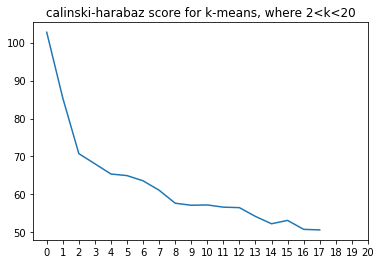

In [174]:
silhouette = [km_fit[k][1] for k in km_fit.keys()]
plt.plot(silhouette)
#plt.axis([0, 20, 0, 1])
plt.title("calinski-harabaz score for k-means, where 2<k<20")
plt.xticks(range(0,21))
plt.show()

   Cluster  Number
2        0     116
5        1       3
0        2    1049
7        3       1
4        4      11
1        5     123
6        6       1
3        7      14
Cluster  0
[('car', 27), ('life', 13), ('reason', 11), ('cost', 10), ('human', 9)]
Cluster  1
[('job', 7), ('company', 3), ('work', 1), ('cost', 1), ('issue', 1)]
Cluster  2
[('technology', 97), ('world', 83), ('human', 78), ('car', 66), ('power', 61)]
Cluster  3
[]
Cluster  4
[('prediction', 5), ('technology', 4), ('life', 3), ('human', 3), ('world', 3)]
Cluster  5
[('human', 11), ('job', 10), ('power', 8), ('technology', 7), ('problem', 7)]
Cluster  6
[('video', 1)]
Cluster  7
[('country', 2), ('work', 2), ('brain', 2), ('company', 1), ('car', 1)]


(array([1.160e+02, 3.000e+00, 1.049e+03, 1.000e+00, 1.100e+01, 1.230e+02,
        1.000e+00, 1.400e+01]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

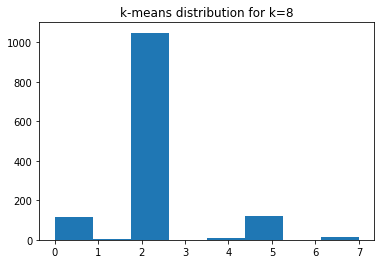

In [176]:
k = 8
selected_km = km_fit[k][2]

#km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=5, random_state=1)
#km.fit(df_rtv)

lfd = FreqDist(selected_km.labels_)
label_df_freq = pd.DataFrame(lfd.most_common(k),
                    columns=['Cluster', 'Number']).sort_values("Cluster")
print(label_df_freq)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(km.labels_))
# print("Completeness: %0.3f" % metrics.completeness_score(km.labels_))
# print("V-measure: %0.3f" % metrics.v_measure_score(lkm.labels_))
# print("Adjusted Rand-Index: %.3f"
#       % metrics.adjusted_rand_score(km.labels_))


label_df = pd.DataFrame(selected_km.labels_,columns=["Cluster"])
#print(label_df.shape)
#print(df_tokenized.shape)
df_token_filter = df_tokenized[df_tokenized.tokenized.apply(lambda row: len(row))>0]
#print(df_token_filter.head(1))
#print(df_token_filter.shape)
#df_rtv = pd.merge(label_df,df_rtv,left_index=True,right_index=True)
df_token_filter = pd.merge(df_token_filter,label_df,left_index=True,right_index=True)
#print(df_token_filter.head(1))

for clustn in np.unique(selected_km.labels_):
    cluster_text = df_token_filter[df_token_filter["Cluster"]==clustn]
    token_list = cluster_text.tokenized.sum(axis=0)
    if(token_list!=False):
        print("Cluster ",clustn)
        cfd = FreqDist(token_list)
        print(cfd.most_common(5))
    else:
        print("Cluster ",clustn)
        print("[]")
      
plt.title("k-means distribution for k=8")
plt.hist(selected_km.labels_,bins=len(np.unique(selected_km.labels_)))

In [ ]:

for clustn in np.unique(selected_km.labels_):
    cluster_text = df_token_filter[df_token_filter["Cluster"]==clustn]
    token_list = cluster_text.tokenized.sum(axis=0)
    if(token_list!=False):
        print("Cluster ",clustn)
        cfd = FreqDist(token_list)
        print(cfd.most_common(5))
    else:
        print("Cluster ",clustn)
        print("[]")
      
plt.title("k-means distribution for k=8")
plt.hist(selected_km.labels_,bins=len(np.unique(selected_km.labels_)))

In [142]:
def tokenize(text):    
    text = reg.sub(repl="", string=text)
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for (word,pos) in pos_tag(tokens) if pos.startswith('NN')]
    tokens = [lemma.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if not exclude.term.str.contains(word).any()]
    tokens = replace_ec(tokens)
    tokens = [word for word in tokens if word.strip()]
    return tokens

In [161]:
km_cluster_assignments_dict = {}

for i in set(selected_km.labels_):
    #print i
    current_cluster = [" ".join(" ".join(df_tokenized.tokenized.loc[x]) for x in np.where(selected_km.labels_ == i)[0])]
    #print(current_cluster)
    km_cluster_assignments_dict[i] = current_cluster

#print(km_cluster_assignments_dict)


km_cluster_themes_dict = {}
for key in km_cluster_assignments_dict.keys():
    if len(km_cluster_assignments_dict[key][0]) > 0:
        current_tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
        current_tfs = current_tfidf.fit_transform(km_cluster_assignments_dict[key])

        current_tf_idfs = dict(zip(current_tfidf.get_feature_names(), current_tfidf.idf_))
        tf_idfs_tuples = current_tf_idfs.items()
        km_cluster_themes_dict[key] = sorted(tf_idfs_tuples, key = lambda x: x[1],reverse=False)[:5]    
        print("Cluster #{0}:{1}".format(key,km_cluster_themes_dict[key]))


Cluster #0:[('brain', 1.0), ('cancer', 1.0), ('car', 1.0), ('change', 1.0), ('china', 1.0)]
Cluster #1:[('company', 1.0), ('cost', 1.0), ('idea', 1.0), ('issue', 1.0), ('job', 1.0)]
Cluster #2:[('air', 1.0), ('brain', 1.0), ('cancer', 1.0), ('car', 1.0), ('change', 1.0)]
Cluster #4:[('car', 1.0), ('computer', 1.0), ('internet', 1.0), ('life', 1.0), ('meat', 1.0)]
Cluster #5:[('air', 1.0), ('brain', 1.0), ('car', 1.0), ('china', 1.0), ('coal', 1.0)]
Cluster #6:[('video', 1.0)]
Cluster #7:[('brain', 1.0), ('car', 1.0), ('company', 1.0), ('country', 1.0), ('earth', 1.0)]


(array([265., 932., 223., 477., 262.]),
 array([-1. , -0.2,  0.6,  1.4,  2.2,  3. ]),
 <a list of 5 Patch objects>)

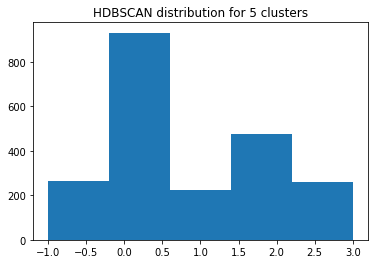

In [177]:
hdb = hdbscan.HDBSCAN(min_cluster_size=150)
hdb.fit(tf_matrix)
#print(np.unique(hdb.labels_))
plt.title("HDBSCAN distribution for 5 clusters")
plt.hist(hdb.labels_,bins=len(np.unique(hdb.labels_)))

In [169]:
hdb_cluster_assignments_dict = {}

for i in set(hdb.labels_):
    #print i
    current_cluster = [" ".join(" ".join(df_tokenized.tokenized.loc[x]) for x in np.where(hdb.labels_ == i)[0])]
    hdb_cluster_assignments_dict[i] = current_cluster

#print(hdb_cluster_assignments_dict)

hdb_cluster_themes_dict = {}
for key in hdb_cluster_assignments_dict.keys():
    if len(hdb_cluster_assignments_dict[key][0]) > 0:
        current_tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
        print(hdb_cluster_assignments_dict[key])
        current_tfs = current_tfidf.fit_transform(hdb_cluster_assignments_dict[key])

        current_tf_idfs = dict(zip(current_tfidf.get_feature_names(), current_tfidf.idf_))
        tf_idfs_tuples = current_tf_idfs.items()
        #print(tf_idfs_tuples)
        hdb_cluster_themes_dict[key] = sorted(tf_idfs_tuples, key = lambda x: x[1],reverse=True)[:5]    
        #print("Cluster #{0}:{1}".format(key,hdb_cluster_themes_dict[key]))

[' country cost car air air   car air internet space money internet mars money  propaganda  company reason company company  space musk space china news question space cost government internet people need company cost change technology company company company technology cost   musk internet hope internet idea musk power power hope power internet internet job    space month internet world  technology musk company power need musk space company world issue government question future  internet internet   month people   musk company industry car change  earth idea space company  industry meat meat meat car meat hope meat meat meat meat meat world need prediction machine human world robot future  technology   power   car power power energy human world issue people brain technology life     power earth plant energy need plant world life technology robot plant   cost musk mars musk cost cost   cost cost technology brain wonder cost car car reason car car car car car car city car cost cost cost 

['world city city machine machine  prediction prediction prediction prediction prediction computer power world computer  life human human technology computer car change musk robot prediction month computer computer machine human power computer  wonder machine power car technology computer  world world world human problem robot brain technology robot prediction human car market car car car car car money   car prediction machine company human future prediction hope   computer human life brain prediction prediction prediction prediction  prediction computer car human brain brain reason industry brain prediction human  life issue brain computer computer power human prediction  car human computer human human problem  car computer government internet human internet technology car cancer technology country reason  market news cost industry market money market company  cost   job work job  need money  news cost industry market cost industry work company cost company issue company   month   wor

['technology job job place energy world power car car  car car energy car car car car car reason car   energy energy change energy power power energy computer idea idea space space space wonder job brain hope meat meat propaganda energy money cancer hope cancer life life life life plant life life life work future life news life car cost  future money technology earth musk  idea  need air   musk  human problem  musk space idea problem idea work car  company job idea musk musk change idea idea place idea    human idea musk musk human air reason   city  company world life musk job musk musk musk  issue musk life money company life month company government work musk government city city space city life government musk power technology life musk machine car car car car money work musk space question musk musk car market market  future  car question car life life problem problem change problem money technology power technology   technology brain idea internet place life brain meat meat  meat

In [171]:
print(hdb_cluster_assignments_dict)
current_tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
current_tfs = current_tfidf.fit_transform(hdb_cluster_assignments_dict)
current_tf_idfs = dict(zip(current_tfidf.get_feature_names(), current_tfidf.idf_))
tf_idfs_tuples = current_tf_idfs.items()
sorted(tf_idfs_tuples, key = lambda x: x[1],reverse=True)[:5]   

{0: [' country cost car air air   car air internet space money internet mars money  propaganda  company reason company company  space musk space china news question space cost government internet people need company cost change technology company company company technology cost   musk internet hope internet idea musk power power hope power internet internet job    space month internet world  technology musk company power need musk space company world issue government question future  internet internet   month people   musk company industry car change  earth idea space company  industry meat meat meat car meat hope meat meat meat meat meat world need prediction machine human world robot future  technology   power   car power power energy human world issue people brain technology life     power earth plant energy need plant world life technology robot plant   cost musk mars musk cost cost   cost cost technology brain wonder cost car car reason car car car car car car city car cost cost c

AttributeError: 'numpy.int64' object has no attribute 'lower'

In [111]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
projection = tsne_model.fit_transform(df_rtv)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1318 samples in 0.046s...
[t-SNE] Computed neighbors for 1318 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1318
[t-SNE] Computed conditional probabilities for sample 1318 / 1318
[t-SNE] Mean sigma: 0.407696
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.762299
[t-SNE] Error after 1000 iterations: 0.990318


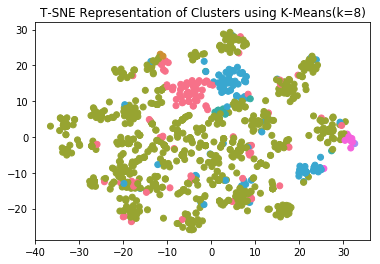

In [116]:
color_palette = sns.color_palette("husl", 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in selected_km.labels_]

plt.title("t-SNE Representation of Clusters using K-Means(k=8)")
plt.scatter(*projection.T,c=cluster_colors)

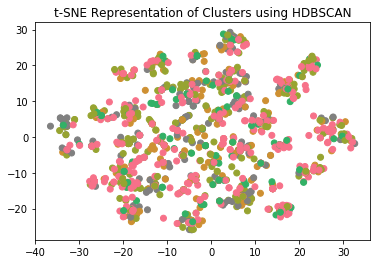

In [178]:
color_palette = sns.color_palette("husl", 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in hdb.labels_]

plt.title("t-SNE Representation of Clusters using HDBSCAN")
plt.scatter(*projection.T,c=cluster_colors)

In [264]:
with open('tf.csv','r',encoding='utf-8') as tf_file:
    df_tokenized = pd.read_csv(tf_file)

df_tokenized.tokenized = df_tokenized.tokenized.apply(lambda row: " ".join(ast.literal_eval(row)))
#print(ast.literal_eval(df_tokenized.tokenized.loc[0]))
print(df_tokenized.head())

   Unnamed: 0                                          tokenized  length
0           0             boy space odyssey joke space hand hand      24
1           1                            amount space get demand      32
2           2                                 drug crime problem      13
3           3  mile confirm cost ownership rotate tire blade ...      50
4           4                              people interest china       9


In [285]:
   
#hdbscan_cluster_matrix = pd.merge(df_tokenized,pd.DataFrame(clusterer.labels_,columns=["Cluster"]),left_index=True,right_index=True)
#print(hdbscan_cluster_matrix.head(10))

#matrix_grouped = hdbscan_cluster_matrix.groupby("Cluster").agg({'tokenized': "sum"})
#print(matrix_grouped)

#matrix_grouped.tokenized = matrix_grouped.tokenized.apply(lambda row: " ".join(row))
#print(matrix_grouped)

#tfidfv = TfidfVectorizer(min_df = 0.0, max_features=100,stop_words = 'english')
#tf_matrix = tfidfv.fit_transform(matrix_grouped.tokenized)

#print(tfidfv.get_feature_names())
#print(tfidfv.idf_)

                                                 tokenized
Cluster                                                   
-1       [   '   d   a   n   g   e   r   '   ,       ' ...
 0       [   '   k   i   m   b   a   l   '   ,       ' ...
 1       [   '   w   o   r   k   '   ,       '   f   o ...
 2       [   '   a   m   a   '   ,       '   w   o   r ...
 3       [   '   m   e   l   t   '   ,       '   o   i ...
 4       [   '   d   r   u   g   '   ,       '   c   r ...
 5       [   '   i   n   d   u   s   t   r   y   '   , ...
 6       [   '   a   m   a   '   ,       '   a   d   v ...
 7       [   '   r   e   m   o   v   a   l   '   ,     ...
 8       [   '   l   i   f   e   '   ,       '   e   v ...
 9       [   '   b   o   y   '   ,       '   s   p   a ...
 10      [   '   m   i   l   e   '   ,       '   c   o ...
 11      [   '   c   o   a   l   '   ,       '   s   t ...
 12      [   '   p   l   a   n   '   ,       '   v   e ...
 13      [   '   k   i   t   c   h   e   n   '   ,     .